In [1]:
import os, random
from os import path
from numpy.random import seed
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
import numpy as np
from distutils.dir_util import copy_tree
import shutil
from PIL import Image
from keras import layers,models
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import ParameterGrid
import tarfile
from tensorflow import random as tfrandom
from keras.callbacks import Callback, CSVLogger
import time
from keras.models import load_model
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt

import cv2

random.seed(42)

In [2]:
base_path=os.getcwd()

In [3]:
base_path


'c:\\Users\\Utilizador\\Desktop\\2_semestre_DS\\Deep_Learning\\DL_GroupProject\\DeepLearning_Group_Project'

In [4]:
dir_path=(base_path+r"\tumor_data")

In [5]:
# rename the images to 1_xx, 2_xx, 3_xx, by the labels 

for _, letter in enumerate(os.listdir(dir_path)):
    folder_letter = os.path.join(dir_path, letter)
 
    counts=0
    for _, image in enumerate(os.listdir(folder_letter)):
        
        dst=image
    
        if '_' in dst:
            continue
        else:
            dst = str(letter) + "_" + str(counts) + ".png"
            #print(dst)
            src = os.path.join(folder_letter, image)
            dst = os.path.join(folder_letter, dst)
            print(counts)
            os.rename(src, dst)
            
        counts=counts+1
        

In [6]:
# define directories for the train, val and test splits
train_path = os.path.join(dir_path, 'train')
val_path = os.path.join(dir_path, 'validation')
test_path = os.path.join(dir_path, 'test')

In [7]:
def createdir(mydir):
    try:
        os.mkdir(mydir)
    except OSError:
        pass

# create the directories

createdir(train_path)
createdir(val_path)
createdir(test_path)

In [8]:
# create the directories for each label for each train, validation and test folders
count=0
for dir in [train_path, val_path, test_path]:
    count+=1
    for letter in ['1','2','3']:
        if count == 1:
            createdir(os.path.join(dir,str("train_{0}".format(str(letter)))))
        elif count == 2:
            createdir(os.path.join(dir,str("val_{0}".format(str(letter)))))   
        elif count == 3:
            createdir(os.path.join(dir,str("test_{0}".format(str(letter)))))
        

In [9]:
# copy all the images for the train folder to then split them for validation and test folders 

count=0

for dir_ in [train_path+r'\train_1', train_path+r'\train_2', train_path+r'\train_3']:
        if len(os.listdir(dir_)) != 0:
            print('break')
            for f in os.listdir(dir_):
                os.remove(os.path.join(dir_, f))
                
for dir in [dir_path+r"\1", dir_path+r"\2", dir_path+r"\3"]:
    count+=1
    
    if count == 1:
        copy_tree(dir, train_path+r'\train_1')
    elif count==2:
        copy_tree(dir, train_path+r'\train_2')
    elif count==3:
        copy_tree(dir, train_path+r'\train_3')

break
break
break


In [10]:
# proportion we want for train, val_test and the test datasets
prop_train=0.80
prop_val_test=0.20
prop_test=0.50 

In [11]:
labels={'label1':708,'label2':1426,'label3':930}

In [12]:
# input images in VALIDATION

count=0
for index, letter in enumerate(os.listdir(train_path)):
    count+=1
    folder_letter_source = os.path.join(train_path, letter)
    folder_letter_destiny_val = os.path.join(val_path, str("val_{0}".format(str(count))))

    images_val = random.sample(os.listdir(folder_letter_source), k=round(prop_val_test*labels['label{0}'.format(str(count))]))
    count1=0
    
    for image in images_val:
        count1+=1
        if count1==1 and len(os.listdir(folder_letter_destiny_val)) != 0:
            print('break')
            for f in os.listdir(folder_letter_destiny_val):
                os.remove(os.path.join(folder_letter_destiny_val, f))
            
        src = os.path.join(folder_letter_source, image)
        dst = os.path.join(folder_letter_destiny_val, image)
        shutil.move(src, dst)


break
break
break


In [13]:
labels['label1']=round(labels['label1']*prop_val_test)
labels['label2']=round(labels['label2']*prop_val_test)
labels['label3']=round(labels['label3']*prop_val_test)
labels

{'label1': 142, 'label2': 285, 'label3': 186}

In [14]:
# input images in TEST

count=0
for index, letter in enumerate(os.listdir(val_path)):
    count+=1
    folder_letter_source = os.path.join(val_path, letter)
    folder_letter_destiny_test = os.path.join(test_path, str("test_{0}".format(str(count))))

    images_val = random.sample(os.listdir(folder_letter_source), k=round(prop_test*labels['label{0}'.format(str(count))]))
    count1=0
    
    for image in images_val:
        count1+=1
        if count1==1 and len(os.listdir(folder_letter_destiny_test)) != 0:
            print('break')
            for f in os.listdir(folder_letter_destiny_test):
                os.remove(os.path.join(folder_letter_destiny_test, f))
            
        src = os.path.join(folder_letter_source, image)
        dst = os.path.join(folder_letter_destiny_test, image)
        shutil.move(src, dst)
        

break
break
break


In [ ]:
train_datagen_aug=ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=50,
                    shear_range=0.05,
                    horizontal_flip=True
                )


train_generator_aug = train_datagen_aug.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical',
    color_mode='grayscale',
)

# val_generator_aug = val_datagen_aug.flow_from_directory(
#     val_path,
#     target_size=(150, 150),  
#     batch_size=20,
#     class_mode='categorical',
#     color_mode='grayscale',
# )

# test_generator_aug = test_datagen_aug.flow_from_directory(
#     test_path,
#     target_size=(150, 150), 
#     batch_size=20,
#     class_mode='categorical',
#     color_mode='grayscale',
#     shuffle=False
# )

In [15]:
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical',
    color_mode='grayscale',
)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(150, 150),  
    batch_size=20,
    class_mode='categorical',
    color_mode='grayscale',
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(150, 150), 
    batch_size=20,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False
)

Found 2451 images belonging to 3 classes.
Found 307 images belonging to 3 classes.
Found 306 images belonging to 3 classes.


In [18]:
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [144]:
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()

In [163]:
def save_times(model, times,name_model):
  
    times_dict = {'Model': ['Model {}'.format(str(name_model))]}
    for idx, time in enumerate(times):
        times_dict[idx] = times[idx]
    df_save_times = pd.DataFrame(times_dict)

    if os.path.exists(r'.\models\models_times.csv'):
        df_save_times.to_csv(r'.\models\models_times.csv', mode='a', header=False, index=False)
    else:
        df_save_times.to_csv(r'.\models\models_times.csv')

In [155]:

def plot_history(his):
    f1 = his['f1_m']
    f1_val=his['val_f1_m']
    loss = his['loss']
    loss_val=his['val_loss']

    epochs=range(1,len(f1)+1)

    plt.plot(epochs, f1,'bo',label='Training F1')
    plt.plot(epochs, f1_val,'b',label='Validation F1')
    plt.title('Training and Validation F1 score')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss,'bo',label='Training loss')
    plt.plot(epochs, loss_val,'b',label='Validation loss')
    plt.title('Training and Validation loss')
    plt.legend()
    plt.figure()

In [149]:
def callback(callname,filename):
  callname=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
            keras.callbacks.ModelCheckpoint(filepath=os.path.join(base_path+ "\models")+filename, monitor='val_loss',mode='min',verbose=1, save_best_only=True)
            ,time_callback]

  return callname

In [150]:
callback(callbacks_BW,"\modelBW.h5")

In [86]:
import math
BATCH_SIZE=20 
TRAINING_SIZE = 2451 
VALIDATION_SIZE = 307 
# We take the ceiling because we do not drop the remainder of the batch 
compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / BATCH_SIZE)) 
steps_per_epoch = compute_steps_per_epoch(TRAINING_SIZE) 
val_steps = compute_steps_per_epoch(VALIDATION_SIZE) 

print(steps_per_epoch)
print(val_steps)

123
16


In [152]:
dependencies = {
    'f1_m': f1_m
}

In [151]:
model = models.Sequential()

model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Flatten())
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=[f1_m])

history_1st = model.fit_generator(train_generator, callbacks=callbacks_BW, epochs=15, steps_per_epoch=123, validation_steps=16,
                                 validation_data=val_generator, workers=2)

Epoch 1/15
123/123 [==============================] - ETA: 0s - loss: 0.8201 - f1_m: 0.5140
Epoch 00001: val_loss improved from inf to 0.65705, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\modelBW.h5
123/123 [==============================] - 131s 1s/step - loss: 0.8201 - f1_m: 0.5140 - val_loss: 0.6571 - val_f1_m: 0.6820
Epoch 2/15
123/123 [==============================] - ETA: 0s - loss: 0.5946 - f1_m: 0.7198
Epoch 00002: val_loss improved from 0.65705 to 0.58316, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\modelBW.h5
123/123 [==============================] - 116s 939ms/step - loss: 0.5946 - f1_m: 0.7198 - val_loss: 0.5832 - val_f1_m: 0.7749
Epoch 3/15
123/123 [==============================] - ETA: 0s - loss: 0.4852 - f1_m: 0.7846
Epoch 00003: val_loss improved from 0.58316 to 0.51218, saving model to c:\Users\Utilizador\Desktop

In [153]:
modelBW = keras.models.load_model('models/modelBW.h5', custom_objects=dependencies)
historyBW=np.load('models/historyBW.npy',allow_pickle='TRUE').item()
timesBW = time_callback.times
save_times(modelBW, timesBW,'modelBW')

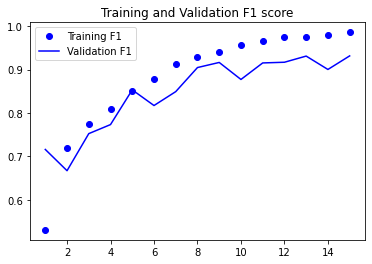

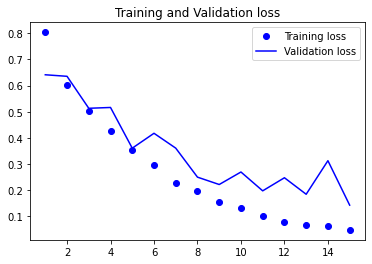

<Figure size 432x288 with 0 Axes>

In [156]:
plot_history(historyBW)

In [157]:
preds = modelBW.predict(test_generator)
predicted_class_indices = np.argmax(preds, axis=1)
test_labels = test_generator.labels

cm = confusion_matrix(test_labels, predicted_class_indices)
test_score = modelBW.evaluate_generator(test_generator)

In [158]:
print(classification_report(test_generator.labels, predicted_class_indices))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89        71
           1       0.95      0.94      0.95       142
           2       0.98      0.99      0.98        93

    accuracy                           0.94       306
   macro avg       0.94      0.94      0.94       306
weighted avg       0.94      0.94      0.94       306



In [125]:
#modelBW.summary()

In [131]:
# test_score_modelBW = modelBW.evaluate_generator(test_generator)
# test_score_modelBW

In [ ]:
# Modelo sem aug BW
#  ---- dropout augmentation

# Modelo sem aug RGB
#  ---- dropout augmentation

# funçoes dos plots

# time function comparison